In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time 
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
from sklearn.model_selection import  train_test_split
import os
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
from random import randint

from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using TensorFlow backend.


In [0]:
!pip install -q kaggle

In [0]:
!mkdir .kaggle

In [0]:
import json

token = {"username":"XXXXXX","key":"ecb0887018abb179b9299bf977d11aec"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
#Configuring the file
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d simjeg/lymphoma-subtype-classification-fl-vs-cll -p /content

 98% 32.0M/32.6M [00:00<00:00, 24.7MB/s]
100% 32.6M/32.6M [00:00<00:00, 51.4MB/s]


In [0]:
import os
import zipfile

local_zip = '/content/lymphoma-subtype-classification-fl-vs-cll.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/lymphoma-subtype-classification-fl-vs-cll')
zip_ref.close()

In [0]:
X = np.load('/content/lymphoma-subtype-classification-fl-vs-cll/X.npy') # images
Y = np.load('/content/lymphoma-subtype-classification-fl-vs-cll/Y.npy') # labels(0 = Non IDC, 1 = IDC)

In [0]:
# Overview of Data
def analyze_data(m,n):
    print('Total Number of Images: {}'.format(len(m)))
    print('Images shape (Width, Height, Channels): {}'.format(m[0].shape))
    print('Number of Non IDC Images: {}'.format(np.sum(n==0)))
    print('Number of IDC Images: {}'.format(np.sum(n==1)))
    print('Percentage of IDC Images: {:.2f}%'.format(100*np.mean(n)))
analyze_data(X,Y)

Total Number of Images: 5547
Images shape (Width, Height, Channels): (50, 50, 3)
Number of Non IDC Images: 2759
Number of IDC Images: 2788
Percentage of IDC Images: 50.26%


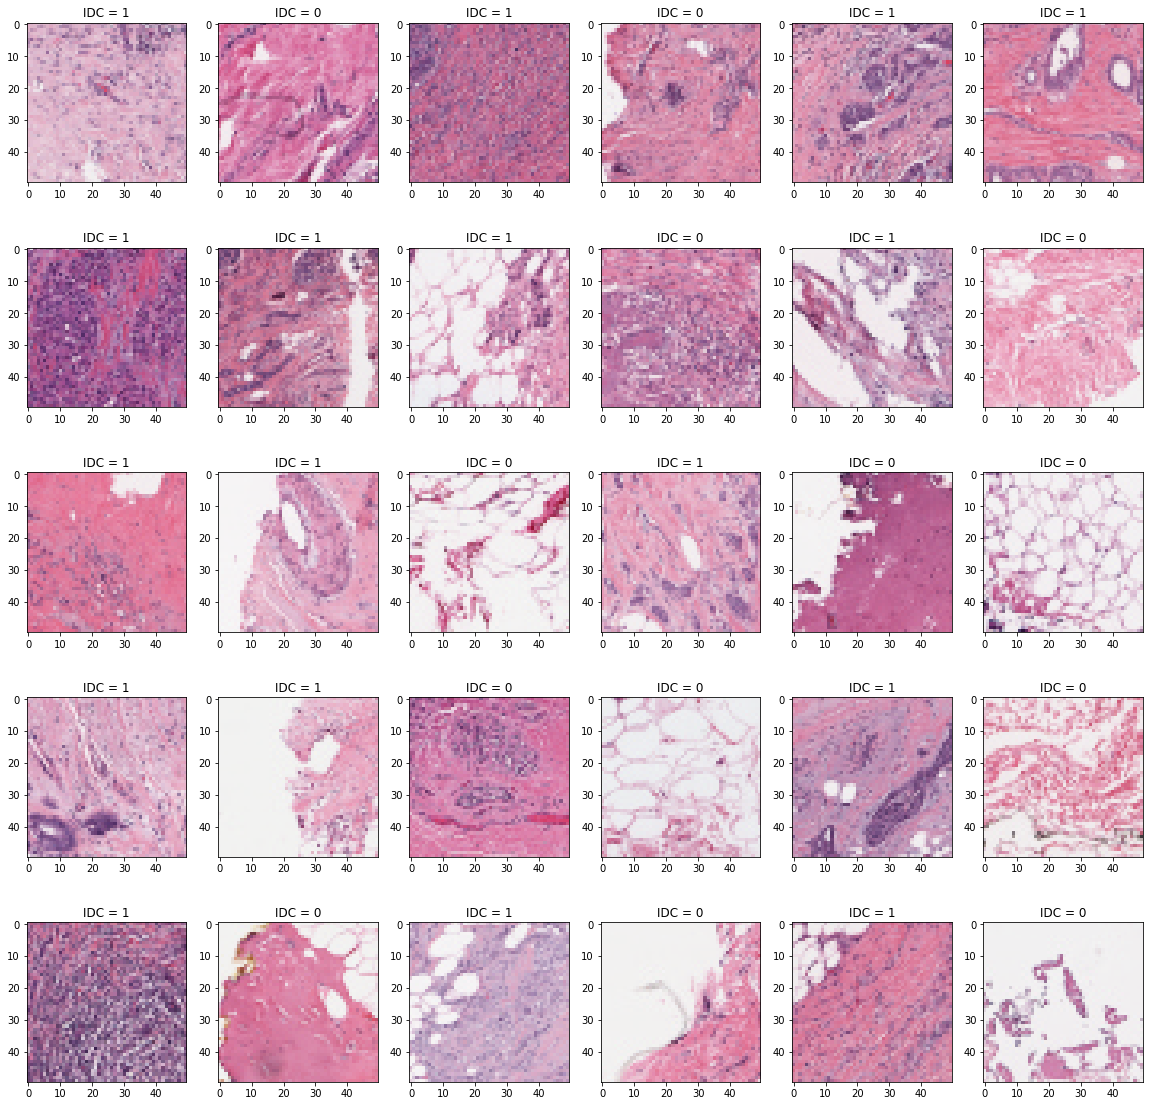

In [0]:
# Shuffling Data
perm_array = np.arange(len(X))
np.random.shuffle(perm_array)
X = X[perm_array]
Y = Y[perm_array]

# Plotting Some Images
imgs_0 = X[Y == 0] # 0 = Non IDC
imgs_1 = X[Y == 1] # 1 = IDC

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

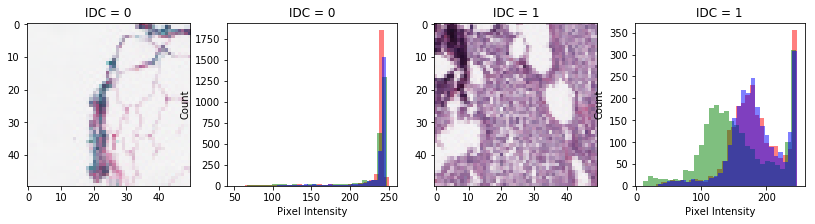

In [0]:
# Plotting Histogram of Red, Green & Blue Pixel Intensities

plt.figure(figsize=(14,3))

for i in range(2):
    n_img = np.random.randint(len(X))
    plt.subplot(1,4,1+2*i)
    plt.title('IDC = %d'%Y[n_img])
    plt.imshow(X[n_img])
    plt.subplot(1,4,2+2*i)
    plt.title('IDC = %d'%Y[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(X[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(X[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(X[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);

In [0]:
Y = Y.reshape(Y.shape[0],1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

# Normalizing the data
X_train = X_train/225
X_test = X_test/225

print("Shape of Training Data:", X_train.shape, X_train.shape)
print("Shape of Validation Data:", X_test.shape, X_test.shape)

Shape of Training Data: (4992, 50, 50, 3) (4992, 50, 50, 3)
Shape of Validation Data: (555, 50, 50, 3) (555, 50, 50, 3)


In [0]:
# Defining Model
model = Sequential()
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(50, 50, 3))

model.add(conv_base)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()





58892288/58889256 [==============================] - 2s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 14,731,137
Trainable params: 14,731,137
Non-tra

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
          loss='binary_crossentropy',
          metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
batch_size = 32
epochs = 30

datagen = ImageDataGenerator(zoom_range=0.2,      
                             rotation_range=0.2,
                             fill_mode="nearest",
                             horizontal_flip = True,
                             vertical_flip=True)

datagen.fit(X_train)

In [0]:
history = model.fit_generator(datagen.flow(X_train,y_train,batch_size = batch_size),
                               steps_per_epoch=(len(X_train)/batch_size),epochs=epochs,
                               validation_data=(X_test,y_test),validation_steps=(len(X_test)/batch_size))



Epoch 1/30
156/156 [==============================] - 21s 136ms/step - loss: 0.6515 - acc: 0.6384 - val_loss: 0.5637 - val_acc: 0.7315
Epoch 2/30
156/156 [==============================] - 16s 101ms/step - loss: 0.5738 - acc: 0.7288 - val_loss: 0.5325 - val_acc: 0.7586
Epoch 3/30
156/156 [==============================] - 16s 102ms/step - loss: 0.5480 - acc: 0.7448 - val_loss: 0.4556 - val_acc: 0.8036
Epoch 4/30
156/156 [==============================] - 16s 102ms/step - loss: 0.5313 - acc: 0.7646 - val_loss: 0.4881 - val_acc: 0.7658
Epoch 5/30
156/156 [==============================] - 16s 102ms/step - loss: 0.5178 - acc: 0.7704 - val_loss: 0.4521 - val_acc: 0.8144
Epoch 6/30
156/156 [==============================] - 16s 102ms/step - loss: 0.5006 - acc: 0.7766 - val_loss: 0.5005 - val_acc: 0.7946
Epoch 7/30
156/156 [==============================] - 16s 102ms/step - loss: 0.4974 - acc: 0.7772 - val_loss: 0.6023 - val_acc: 0.7514
Epoch 8/30
156/156 [==============================] -

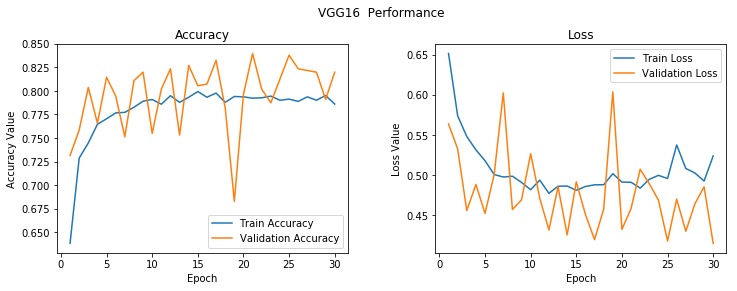

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16  Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save("VGG_16%")